In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nibabel as nib
import pandas as pd
from hmmlearn import hmm
import scipy.stats as scp
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import random
import pickle
from subprocess import check_call
import os

sns.set(context='talk',style='white')

hbn_folder = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study'
project_folder = '/Users/catcamacho/Library/CloudStorage/Box-Box/SEAL/stickystates'
data_folder = os.path.join(project_folder, 'DATA','hbn')
ts_folder = os.path.join(data_folder, 'sub')
atlas_folder = os.path.join(hbn_folder, 'proc','null_lL_WG33')
out_folder = os.path.join(project_folder, 'ANALYSIS','hbn_brain_states_final', 'otheratlases')
medial_wall = os.path.join(atlas_folder, 'Human.MedialWall_Conte69.32k_fs_LR.dlabel.nii')

sample_file = os.path.join(hbn_folder,'social_proc_networks','dynamic_connectivity','DATA', 
                           'helper_files','sample_gord.32k_fs_LR.pscalar.nii')

# get parcel and network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

# define measures of interest
atlasnames = ['Yeo7networks','Yeo17networks','Power_Neuron11']
networks_of_interest = ['Auditory', 'CinguloOperc', 'Default', 'DorsalAttn', 'FrontoParietal',
                        'SMhand', 'SMmouth', 'Salience', 'VentralAttn', 'Visual']
networks_palette = ['#FF00FF','#800080','#FF0000','#00FF00','#FFFF00','#00FFFF','#FF8000',
                    '#000000','#008080','#0000BD']

features_of_interest = ['Positive','Negative','Anger','Happy','Fear','Sad','Excited','Brightness',
                        'SaliencyFract','Sharpness','Vibrance','Loudness','Motion']
timing = np.round(np.arange(0,600,0.8),1) # for DM

state_palette = ['#7F7F7F','#05159b', '#cf28cf', '#008c8c']

# parcellate and compile data using Yeo and Power networks

In [23]:
# split dlabel file 
yeo_dlabel = nib.load(os.path.join(atlas_folder, 'RSN-networks_converted_resampled.32k_fs_LR.dlabel.nii'))
gordon_dlabel = nib.load(os.path.join(atlas_folder, 'Gordon333_nosubcort.32k_fs_LR.dlabel.nii'))
dlabel_axis = yeo_dlabel.header.get_axis(0)
gbrain = gordon_dlabel.header.get_axis(1)

for i, l in enumerate(dlabel_axis.label[:3]):
    data = np.expand_dims(yeo_dlabel.get_fdata()[i,:], axis=0)
    ax1 = yeo_dlabel.header.get_axis(1)

    mwdata = nib.load(medial_wall).get_fdata()
    data[mwdata==1] = 0
    
    if 'Power' not in atlasnames[i]:
        lnew = {}
        
        for x in np.unique(data):
            if x!=37:
                lnew[x] = l[x]
        ax0 = nib.cifti2.LabelAxis(name=np.array([atlasnames[i]]), label=lnew, meta=[{}])
        
    else:
        newvals = [16, 4, 14, 3, 15, 6, 9]
        oldvals = [27, 28, 29, 31, 32, 33, 62]
        for j, x in enumerate(oldvals):
            data[data==x] = newvals[j]
        l = {
        0: ('???', (0.667, 0.667, 0.667, 0.0)),
        3: ('Default_mode', (1.0, 0.0, 0.0, 1.0)),
        4: ('Hand_somatosensory-motor', (0.0, 1.0, 1.0, 1.0)),
        5: ('Visual', (0.0, 0.0, 1.0, 1.0)),
        6: ('Fronto-parietal', (0.961, 0.961, 0.059, 1.0)),
        7: ('Ventral_attention', (0.0, 0.502, 0.502, 1.0)),
        9: ('Language_Superior_temporal_gyrus', (1.0, 0.722, 0.827, 1.0)),
        14: ('Cingulo-opercular', (0.502, 0.0, 0.502, 1.0)),
        15: ('Dorsal_attention', (0.0, 0.863, 0.0, 1.0)),
        16: ('Mouth_somatosensory-motor', (1.0, 0.502, 0.0, 1.0)),
        20: ('Salience', (0.0, 0.0, 0.0, 1.0)),
        24: ('Auditory', (1.0, 0.0, 1.0, 1.0))
        }
        newvals = l.keys()
        for x in np.unique(data):
            if x not in newvals:
                data[data==x] = 0
        ax0 = nib.cifti2.LabelAxis(name=np.array([atlasnames[i]]), label=l, meta=[{}])
    img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
    nib.save(img, os.path.join(atlas_folder, '{0}.32k_fs_LR.dlabel.nii'.format(atlasnames[i])))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [51]:
subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movieDM.csv'), index_col=0)

for atlas in atlasnames:
    atlas_file = os.path.join(atlas_folder, '{0}.32k_fs_LR.dlabel.nii'.format(atlas))
    for sub in subinfo.index:
        outfile = os.path.join(ts_folder,'{0}_task-movieDM_bold1_AP_Atlas_demean_detrend_resid0.9_filt_{1}.32k_fs_LR.ptseries.nii'.format(sub,atlas))
        infile = os.path.join(ts_folder,'{0}_task-movieDM_bold1_AP_Atlas_demean_detrend_resid0.9_filt.32k_fs_LR.dtseries.nii'.format(sub))
        if (not os.path.isfile(outfile)):
            check_call(['wb_command','-cifti-parcellate',infile, atlas_file, 'COLUMN', outfile, '-only-numeric'])

In [53]:
def compile_ts_data(subdf, movie, atlas, datadir, outfile, motionfile):
    """
    combine data for each movie together into 1 file
    
    Parameters
    ----------
    subdf: DataFrame
        A dataframe with subject IDs as the index. Includes IDs for all usable data.
    movie: str
        Corresponds with the str for the movie content to concatenate (e.g., "DM" or "TP").
    atlas:
    datadir: folder path
        Path to folder with the subject timeseries ciftis.
    outfile: file path
        Path including filename to save the output data of shape Ntimepoints x Nparcels x Nsubjects.
    
    Returns
    -------
    data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    """
    
    if not isinstance(subdf, pd.DataFrame):
        subdf = pd.read_csv(subdf, index_col=0)
    
    for sub in subdf.index:
        file = '{0}/{1}_task-movie{2}_bold1_AP_Atlas_demean_detrend_resid0.9_filt_{3}.32k_fs_LR.ptseries.nii'.format(datadir,sub, movie, atlas)
        #motion = np.loadtxt('{0}/{1}/{1}_task-movie{2}_bold1_AP_FD.txt'.format(datadir,sub, movie))
        if sub == subdf.index[0]:
            data = StandardScaler().fit_transform(nib.load(file).get_fdata())
            data = np.expand_dims(data, axis=2)
            #motiondata = np.expand_dims(motion, axis=1)
        else:
            t = StandardScaler().fit_transform(nib.load(file).get_fdata())
            t = np.expand_dims(t, axis=2)
            #motion = np.expand_dims(motion, axis=1)
            data = np.concatenate([data,t],axis=2)
            #motiondata = np.concatenate([motiondata,motion],axis=1)
    
    print('Compile data from {0} brain regions measured at {1} timepoints from {2} participants.'.format(data.shape[1],data.shape[0],data.shape[2]))
    np.save(outfile, data)
    #np.save(motionfile, motiondata)


subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movieDM.csv'), index_col=0)
motionfile = os.path.join(data_folder, 'compiled_motion_data_movieDM.npy')

for atlas in atlasnames:
    outfile = os.path.join(data_folder, 'compiled_ts_data_movieDM_{0}.npy'.format(atlas))
    compile_ts_data(subinfo, 'DM', atlas, ts_folder, outfile, motionfile)

Compile data from 7 brain regions measured at 750 timepoints from 620 participants.
Compile data from 17 brain regions measured at 750 timepoints from 620 participants.
Compile data from 11 brain regions measured at 750 timepoints from 620 participants.


# train model on Despicable Me and find optimal states

In [3]:
movie='DM'

for atlas in atlasnames:
    subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movie{0}.csv'.format(movie)), index_col=0)
    func_file = os.path.join(data_folder, 'compiled_ts_data_movie{0}_{1}.npy'.format(movie, atlas))
    motion = np.load(os.path.join(data_folder, 'compiled_motion_data_movie{0}.npy'.format(movie)))
    func_data = np.load(func_file)
    
    # split data into discovery and replication
    disc_data = func_data[:,:, subinfo['site']=='rubic']
    disc_motion = motion[:, subinfo['site']=='rubic']
    disc_info = subinfo.loc[subinfo['site']=='rubic',:]
    
    t_concat_disc = []
    for i in range(0, disc_data.shape[2]):
        m = disc_motion[:,i]
        t = disc_data[:,:,i]
        t_concat_disc.append(t[m<0.9,:])
    t_concat_disc = np.concatenate(t_concat_disc, axis=0)
    
    rep_data = func_data[:,:, subinfo['site']=='cbic']
    rep_motion = motion[:, subinfo['site']=='cbic']
    rep_info = subinfo.loc[subinfo['site']=='cbic',:]
    
    t_concat_rep = []
    for i in range(0, rep_data.shape[2]):
        t = rep_data[:,:,i]
        m = rep_motion[:,i]
        t_concat_rep.append(t[m<0.9,:])
    t_concat_rep = np.concatenate(t_concat_rep, axis=0)
    
    # save datasets
    np.save(os.path.join(data_folder, 'movie{0}_disc_concat_data_{1}.npy'.format(movie, atlas)), t_concat_disc)
    np.save(os.path.join(data_folder, 'movie{0}_rep_concat_data_{1}.npy'.format(movie, atlas)), t_concat_rep)

2
3
4
5
6
7
8
9


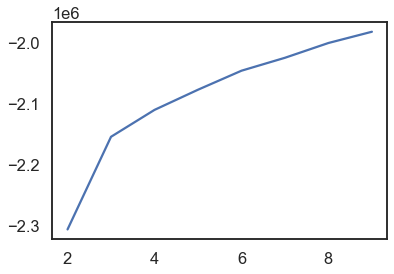

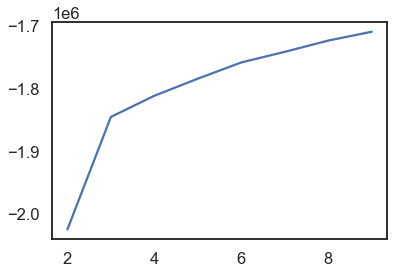

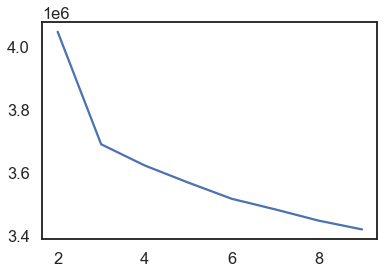

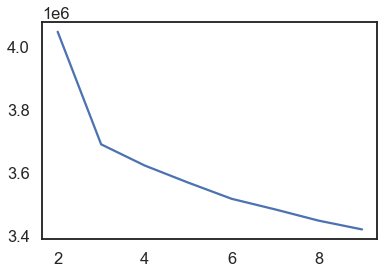

2
3
4
5
6
7
8
9


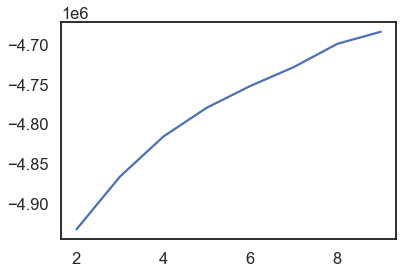

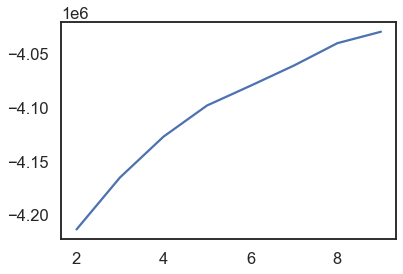

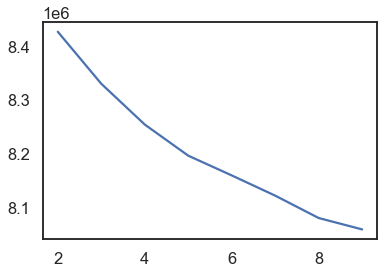

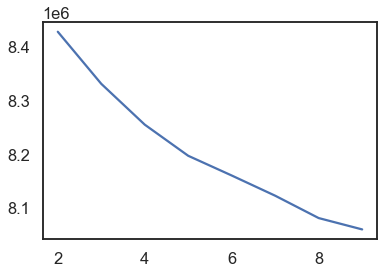

2
3
4
5
6
7
8
9


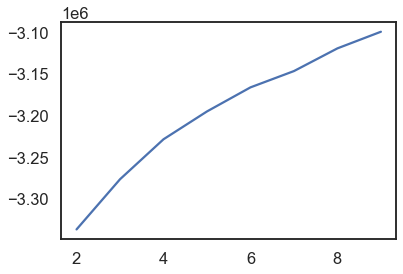

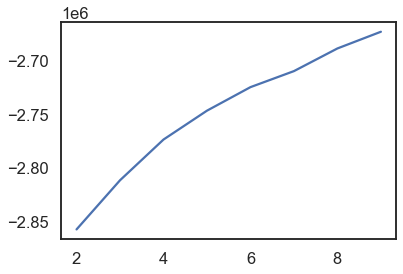

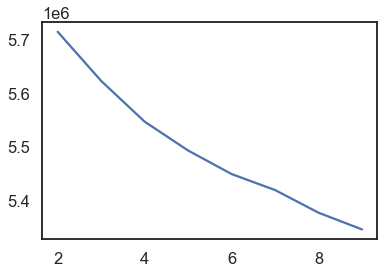

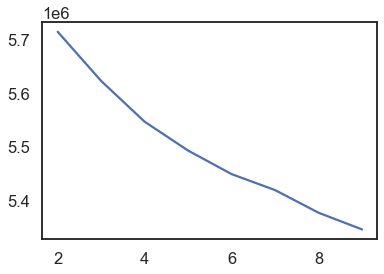

In [8]:
for atlas in atlasnames:

    model_fit = pd.DataFrame()

    for k in range(2,10):
        print(k)
        t_concat_disc = np.load(os.path.join(data_folder, 'movie{0}_disc_concat_data_{1}.npy'.format(movie, atlas)))
        t_concat_rep = np.load(os.path.join(data_folder, 'movie{0}_rep_concat_data_{1}.npy'.format(movie, atlas)))
        model = hmm.GMMHMM(n_components=k, covariance_type="full", n_iter=10000)
        model.fit(t_concat_disc)
    
        # save scores
        train_score = model.score(t_concat_disc)
        test_score, _ = model.decode(t_concat_rep)
        n_params = model.covars_.shape[0]*model.covars_.shape[1]*model.covars_.shape[2]
        test_a = -2*test_score + 2*n_params
        test_b = -2*test_score + n_params*np.log(t_concat_rep.shape[0])
    
        model_fit.loc[k, 'n_states'] = k
        model_fit.loc[k,'train_ll'] = train_score
        model_fit.loc[k,'test_ll'] = test_score
        model_fit.loc[k,'test_aic'] = test_a
        model_fit.loc[k,'test_bic'] = test_b
    
    plt.plot(model_fit['n_states'],model_fit['train_ll'])
    plt.savefig(os.path.join(out_folder,'movieDM_train_model_fit_plot_{0}.png'.format(atlas)))
    plt.show()
    plt.close()
    
    plt.plot(model_fit['n_states'],model_fit['test_ll'])
    plt.savefig(os.path.join(out_folder,'movieDM_test_model_fit_plot_{0}.png'.format(atlas)))
    plt.show()
    plt.close()
    
    plt.plot(model_fit['n_states'],model_fit['test_aic'])
    plt.savefig(os.path.join(out_folder,'movieDM_test_model_fit_aic_plot_{0}.png'.format(atlas)))
    plt.show()
    plt.close()
    
    plt.plot(model_fit['n_states'],model_fit['test_bic'])
    plt.savefig(os.path.join(out_folder,'movieDM_test_model_fit_bic_plot_{0}.png'.format(atlas)))
    plt.show()
    plt.close()
    
    model_fit.to_csv(os.path.join(out_folder,'movieDM_model_fit_stats_{0}.csv'.format(atlas)))

## fit and save optimal model

In [9]:
movie='DM'
nstates=3
for atlas in atlasnames[1:]:
    t_concat_disc = np.load(os.path.join(data_folder, 'movie{0}_disc_concat_data_{1}.npy'.format(movie, atlas)))
    
    # fit and save optimal model
    model = hmm.GMMHMM(n_components=nstates, covariance_type="full", n_iter=10000)
    model.fit(t_concat_disc)
    
    # save outputs
    pickle.dump(model, open(os.path.join(out_folder,'movieDM_k{0}_{1}_model.pkl'.format(nstates, atlas)), 'wb'))

#### Compute CIs

In [10]:
# load data and set up model
movie='DM'
nstates=3

for atlas in atlasnames:
    train_data_file = os.path.join(data_folder, 'movie{0}_disc_concat_data_{1}.npy'.format(movie, atlas))
    model = pickle.load(open(os.path.join(out_folder,'movieDM_k{0}_{1}_model.pkl'.format(nstates, atlas)), 'rb'))
    
    # bootstrapping parameters
    nboots = 1000
    lowern = 0.1
    uppern = 0.3
    ci = 95
    samplen = np.load(train_data_file).shape[0]
    
    boot_results = np.empty((nstates, nstates, nboots))
    
    for i in range(nboots):
        # subset data
        bootsample_size = random.randint(int(samplen*lowern),int(samplen*uppern))
        subsampmask = np.full(samplen, 0)
        subsampmask[:bootsample_size] = 1
        start = random.randint(0,samplen-int(samplen*uppern))
        subsampmask = np.roll(subsampmask, start)
        temp = np.load(train_data_file)[subsampmask==1,:]
        res = model.decode(temp)[1]
        
        # fit the model
        transitions = np.zeros((nstates, nstates))
        for j in range(res.shape[0]-1):
            s = res[j]
            sn = res[j+1]
            transitions[s,sn] = transitions[s,sn]+1
        marg0_subtra = np.sum(transitions, axis=0)
        boot_results[:,:,i] = transitions/marg0_subtra
    
    means = np.mean(boot_results, axis=2)
    lowerCI = np.percentile(boot_results, (100-ci)/2, axis=2, keepdims=True)
    upperCI = np.percentile(boot_results, 100-((100-ci)/2), axis=2, keepdims=True)
    
    results = pd.DataFrame()
    for a in range(nstates):
        for b in range(nstates):
            results.loc['s{0}_s{1}'.format(a+1,b+1), 'mean'] = means[a,b]
            results.loc['s{0}_s{1}'.format(a+1,b+1), 'lowerCI'] = lowerCI[a,b]
            results.loc['s{0}_s{1}'.format(a+1,b+1), 'upperCI'] = upperCI[a,b]
    results.to_csv(os.path.join(out_folder, 'transition_probabilities_CI_k{0}_{1}.csv'.format(nstates, atlas)))

SyntaxError: unmatched ')' (3920650850.py, line 6)

## Test model significance

In [ ]:
nstates=3
nperms=10000
movie='DM'

for atlas in atlasnames:

    model_fit = pd.DataFrame()
    
    model = pickle.load(open(os.path.join(out_folder,'movieDM_k{0}_{1}_model.pkl'.format(nstates, atlas)), 'rb'))
    t_concat_rep = np.load(os.path.join(data_folder, 'movie{0}_rep_concat_data_{1}.npy'.format(movie, atlas)))
    origdims = t_concat_rep.shape
    
    for i in range(nperms):
        temp = t_concat_rep.flatten()
        np.random.shuffle(temp)
        t_concat_rep_perm = np.reshape(temp, origdims)
        test_score, _ = model.decode(t_concat_rep_perm)
        n_params = model.covars_.shape[0]*model.covars_.shape[1]*model.covars_.shape[2]
        test_a = -2*test_score + 2*n_params
        test_b = -2*test_score + n_params*np.log(t_concat_rep.shape[0])
    
        model_fit.loc[i,'test_ll'] = test_score
        model_fit.loc[i,'test_aic'] = test_a
        model_fit.loc[i,'test_bic'] = test_b
    
    actual_fit = pd.read_csv(os.path.join(out_folder,'movieDM_model_fit_stats_{0}.csv'.format(atlas)), index_col=0)
    
    for stat in model_fit.columns:
        fig, ax = plt.subplots(figsize=(6,3))
        ax.hist(model_fit.loc[:,stat], 20, label='Permutated Scores', density=False)
        ax.axvline(actual_fit.loc[3,stat], ls='--', color='r', label='Actual Model Fit')
        plt.legend()
        plt.xlabel('Score')
        plt.tight_layout()
        plt.savefig(os.path.join(out_folder, 'permutation_plot_{0}_{1}.png'.format(stat, atlas)), dpi=300)
        plt.close()

    perm_stats = pd.DataFrame()
    for stat in model_fit.columns:
        if stat!='test_ll':
            pvalue=(np.sum((model_fit.loc[:,stat]<=actual_fit.loc[3,stat]).astype(int)) + 1) / (nperms + 1)
            perm_stats.loc[stat, 'actual_stat'] = actual_fit.loc[3,stat]
            perm_stats.loc[stat, 'perm_pval'] = pvalue
        else:
            pvalue=(np.sum((model_fit.loc[:,stat]>=actual_fit.loc[3,stat]).astype(int)) + 1) / (nperms + 1)
            perm_stats.loc[stat, 'actual_stat'] = actual_fit.loc[3,stat]
            perm_stats.loc[stat, 'perm_pval'] = pvalue
    model_fit.to_csv(os.path.join(out_folder, 'permuation_testing_permresults_{0}.csv'.format(atlas)))
    perm_stats.to_csv(os.path.join(out_folder, 'permuation_testing_perm_stats_{0}.csv'.format(atlas)))

## apply model to all participant data

In [16]:
nstates=3
movie='DM'
for atlas in atlasnames:
    model = pickle.load(open(os.path.join(out_folder,'movieDM_k{0}_{1}_model.pkl'.format(nstates, atlas)), 'rb'))
    
    subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movie{0}.csv'.format(movie)), index_col=0)
    func_data = np.load(os.path.join(data_folder, 'compiled_ts_data_movie{0}_{1}.npy'.format(movie, atlas)))
    motion = np.load(os.path.join(data_folder, 'compiled_motion_data_movie{0}.npy'.format(movie)))
    
    mean_netact_df = pd.DataFrame()
    state_info_df = pd.DataFrame()
    sample_states = []
    state_prob = {0:pd.DataFrame(columns=timing, dtype=float, index=subinfo.index),
                  1:pd.DataFrame(columns=timing, dtype=float, index=subinfo.index),
                  2:pd.DataFrame(columns=timing, dtype=float, index=subinfo.index),
                  3:pd.DataFrame(columns=timing, dtype=float, index=subinfo.index)}
    ind = 0
        
    for i, sub in enumerate(subinfo.index):
        sample_file = os.path.join(ts_folder, 'sub-NDARAA504CRN_task-movieDM_bold1_AP_Atlas_demean_detrend_resid0.9_filt_{0}.32k_fs_LR.ptseries.nii'.format(atlas))
        networks = nib.load(sample_file).header.get_axis(1).name
        sub_data = func_data[:,:,i]
        sub_data = StandardScaler().fit_transform(sub_data)
        sub_motion = motion[:,i]
        res = np.zeros((net_func_data.shape[0],))
        res[sub_motion<0.9] = model.decode(sub_data[sub_motion<0.9,:])[1] + 1
        sample_states.append(np.expand_dims(res,0))
        prob = model.predict_proba(sub_data)
        prob[sub_motion>=0.9,:] = np.nan
        np.save(os.path.join(out_folder,'sub','{0}_movie{1}_k{2}_{3}_states.npy'.format(sub, movie, nstates, atlas)), res)
        np.save(os.path.join(out_folder,'sub','{0}_movie{1}_k{2}_{3}_state_probabilities.npy'.format(sub, movie, nstates, atlas)), prob)
        for s in range(1, nstates+1): 
            mask = res==s
            state_info_df.loc[sub,'s{0}_percent'.format(s)] = np.nanmean(mask)*100
            if s in res:
                state_prob[s].loc[sub,:] = prob[:,s-1]
                mean_netact_df.loc[ind,'sub'] = sub
                mean_netact_df.loc[ind,'state'] = s
                mean_netact_df.loc[ind,networks] = np.mean(sub_data[mask,:], axis=0)
                ind = ind + 1
    
    group_data = np.concatenate(sample_states, axis=0)
    group_data = np.squeeze(group_data)
    np.save(os.path.join(out_folder,'group-movie{0}_k{1}_{2}_states.npy'.format(movie, nstates, atlas)), group_data)
    
    state_info_df.to_csv(os.path.join(out_folder, 'movie{0}_{1}_states_info.csv'.format(movie, atlas)))
    mean_netact_df.to_csv(os.path.join(out_folder, 'movie{0}_{1}_mean_netact.csv'.format(movie, atlas)))
    pickle.dump(state_prob, open(os.path.join(out_folder,'movie{0}_k{1}_{2}_state_probabilities.pkl'.format(movie, nstates, atlas)), 'wb'))

(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)
(750,)
(750, 7)

In [45]:
# compute mean probabilities
for atlas in atlasnames:
    mean_probs = pd.DataFrame(index=timing)
    state_prob = pickle.load(open(os.path.join(out_folder,'movie{0}_k{1}_{2}_state_probabilities.pkl'.format(movie, nstates, atlas)), 'rb'))
    for s in range(1,4):
        mean_probs.loc[:,'s{0}'.format(s)] = state_prob[s].mean(axis=0).to_numpy()
    mean_probs.to_csv(os.path.join(out_folder, 'movie{0}_k3_{1}_meanprobs.csv'.format(movie, atlas)))

## Compute individual transition odds ratios

In [37]:
for atlas in atlasnames:

    odds_ratios = pd.DataFrame()
    subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movieDM.csv'), index_col=0)
    for sub in subinfo.index:
        substates = np.load(os.path.join(out_folder,'sub','{0}_movieDM_k{1}_{2}_states.npy'.format(sub, nstates, atlas))).astype(int)
        # overall video
        subtransitions = np.zeros((nstates+1, nstates+1))
        for i in range(1, substates.shape[0]-1):
            s = substates[i]
            sn = substates[i+1]
            subtransitions[s,sn] = subtransitions[s,sn]+1
        marg0_subtra = np.sum(subtransitions, axis=0)
        odds = subtransitions/marg0_subtra
        states = np.arange(1,nstates+1).astype(int).tolist()
        for s1 in states:
            for s2 in states:
                odds_ratios.loc[sub,'ntrans_s{0}_to_{1}_all'.format(s1,s2)] = subtransitions[s1,s2]
        for s1 in states:
            for s2 in states:
                odds_ratios.loc[sub,'s{0}_to_{1}_all'.format(s1,s2)] = odds[s1,s2]
        for i in range(1, nstates+1):
            states = np.arange(1,nstates+1).astype(int).tolist()
            states.remove(i)
            odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_all'.format(i, states[0],states[1])] = odds[i,states[0]]/odds[i,states[1]]
            odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_all'.format(i, states[1],states[0])] = odds[i,states[1]]/odds[i,states[0]]
    odds_ratios = odds_ratios.replace(np.inf,np.nan)
    odds_ratios.to_csv(os.path.join(out_folder, 'movieDM_{0}_sample_oddsratios.csv'.format(atlas)))

/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_62237/1262646508.py:14: RuntimeWarning: invalid value encountered in divide
  odds = subtransitions/marg0_subtra
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_62237/1262646508.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_all'.format(i, states[0],states[1])] = odds[i,states[0]]/odds[i,states[1]]
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_62237/1262646508.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_all'.format(i, states[1],states[0])] = odds[i,states[1]]/odds[i,states[0]]


## make plots

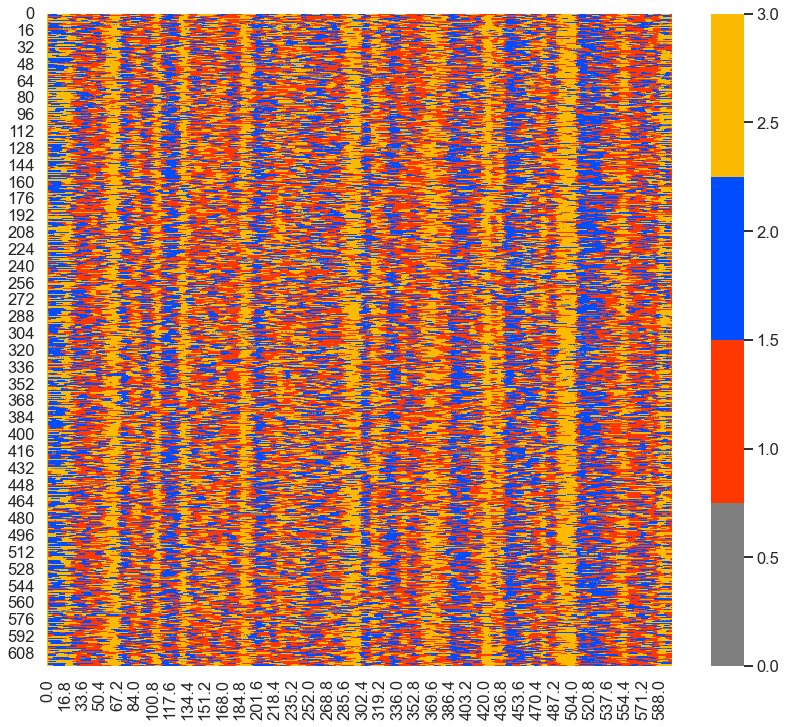

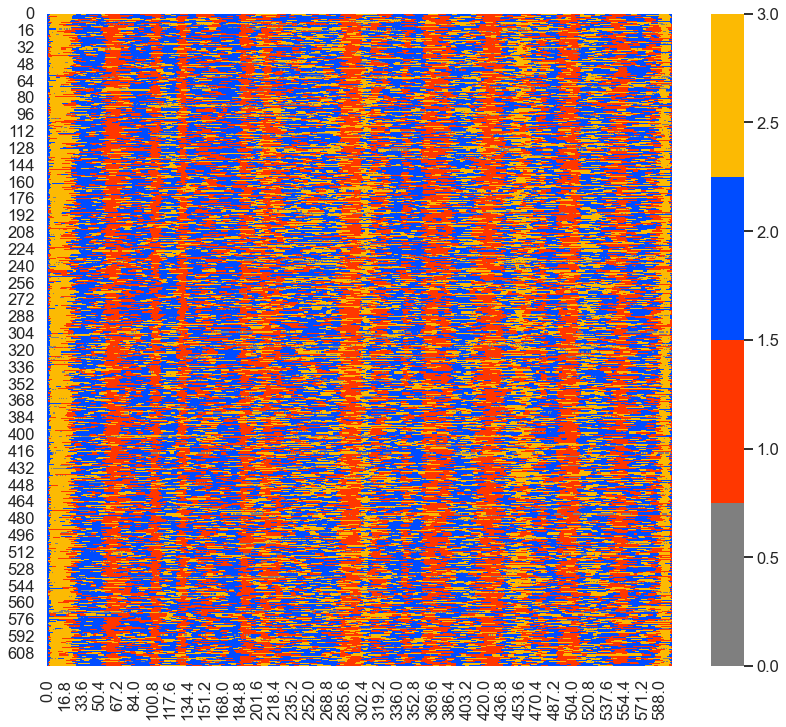

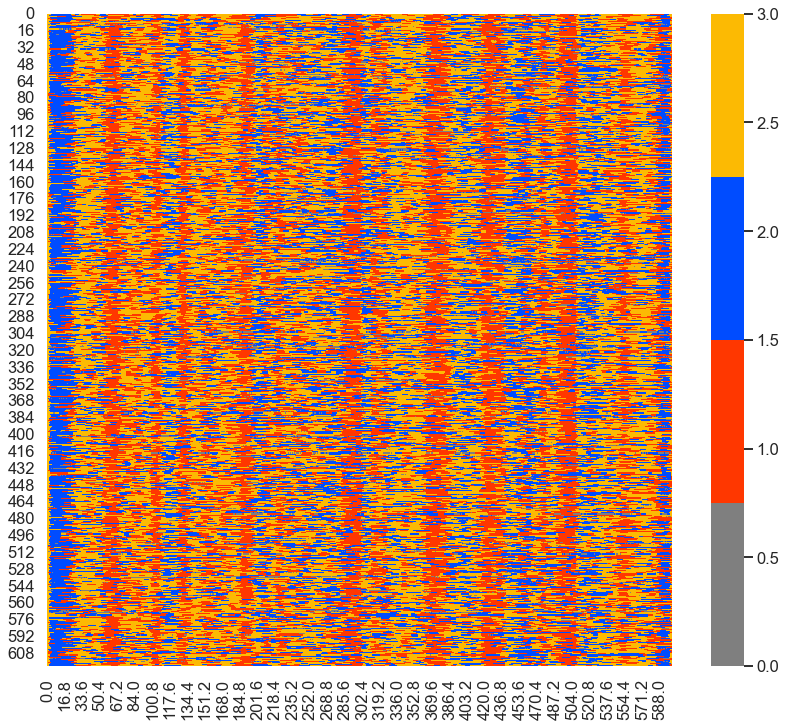

In [19]:
# plot overall brain states for each movie
for atlas in atlasnames:
    state_palette = ['#ff3700', '#004cff', '#fcba03']
    nstates=3
    group_data = np.load(os.path.join(out_folder,'group-movieDM_k{0}_{1}_states.npy'.format(nstates, atlas)))
    
    
    # plot states across the sample
    sample_res_df = pd.DataFrame(group_data, columns=timing)
    sns.set(context='talk', style='white')
    plt.figure(figsize=(14,12))
    sns.heatmap(sample_res_df, cmap=['#7F7F7F']+state_palette)
    plt.savefig(os.path.join(out_folder,'group-movieDM_k{0}_states_sample_{1}.png'.format(nstates, atlas)), dpi=300)

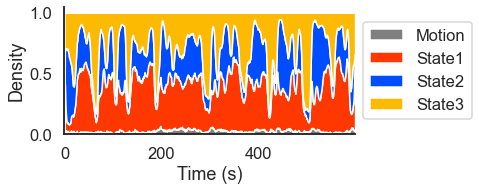

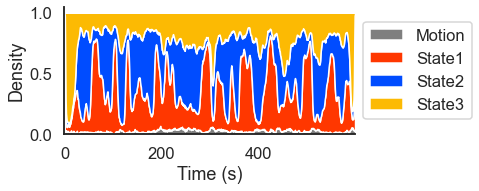

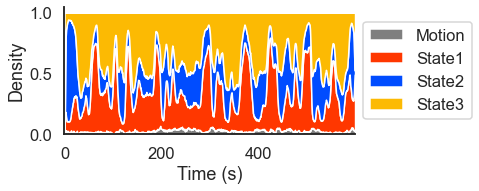

In [20]:
state_palette = ['#ff3700', '#004cff', '#fcba03']
for atlas in atlasnames:
    group_data = np.load(os.path.join(out_folder,'group-movieDM_k3_{0}_states.npy'.format(atlas)))
    sample_res_df = pd.DataFrame(np.squeeze(group_data), columns=timing)
    
    states_counts_df = pd.DataFrame()
    for i in sample_res_df.columns:
        states_counts_df.loc[i,'s0'] = sum(sample_res_df[i]==0)
        states_counts_df.loc[i,'s1'] = sum(sample_res_df[i]==1)
        states_counts_df.loc[i,'s2'] = sum(sample_res_df[i]==2)
        states_counts_df.loc[i,'s3'] = sum(sample_res_df[i]==3)
    
    data_perc = states_counts_df.divide(states_counts_df.sum(axis=1), axis=0)
    
    # Make the plot
    plt.figure(figsize=(7,3))
    plt.stackplot(data_perc.index, data_perc["s0"], data_perc["s1"],  data_perc["s2"], data_perc["s3"],
                  labels=[ 'Motion', 'State1', 'State2','State3'], 
                  colors=['#7F7F7F']+ state_palette)
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    plt.xlim(0,timing[-1])
    plt.ylabel('Density')
    plt.xlabel('Time (s)')
    sns.despine()
    plt.tight_layout()
    plt.savefig(os.path.join(out_folder,'group-movieDM_k3_states_density_{0}.png'.format(atlas)), dpi=300)
    plt.show()

In [27]:
atlas_info = {
    'Yeo7networks': {
        'datalabels': ['7Networks_3', '7Networks_6', '7Networks_7', '7Networks_1', '7Networks_5',
                       '7Networks_2', '7Networks_4'], 
        'plotlabels': ['DorsalAttention', 'FrontoParietal', 'Default', 'Visual', 'Limbic',
                       'SomatoMotor', 'VentralAttention'], 
        'plotcolors': ['#298834', '#e7a244', '#de5f6e', '#93399e', '#eaffb8', '#679cc9', '#d75bff']
    }, 
    'Yeo17networks': {
        'datalabels': ['17Networks_1', '17Networks_2', '17Networks_3', '17Networks_4',
                       '17Networks_5', '17Networks_6', '17Networks_7', '17Networks_8',
                       '17Networks_9', '17Networks_10', '17Networks_11', '17Networks_12',
                       '17Networks_13', '17Networks_14', '17Networks_15' ,'17Networks_16',
                       '17Networks_17'], 
        'plotlabels': ['N{0}'.format(a) for a in range(1,18)], 
        'plotcolors': ['#693370', '#ff2929', '#679cc9', '#4edeb9', '#5a9251', '#297732', '#c456ee', 
                       '#ffafe5', '#d5eba9', '#929d53', '#91a2c2', '#da9957', '#975165', '#3252ff', 
                       '#29298e', '#fefe29', '#dd5e6d']
    }, 
    'Power_Neuron11': {
        'datalabels': ['Default_mode', 'Hand_somatosensory-motor', 'Visual', 'Fronto-parietal',
                       'Ventral_attention', 'Language_Superior_temporal_gyrus',
                       'Cingulo-opercular', 'Dorsal_attention', 'Mouth_somatosensory-motor',
                       'Salience', 'Auditory'], 
        'plotlabels': ['Default', 'Hand_somatomotor', 'Visual', 'Frontoparietal',
                       'Ventral_attention', 'Language_STG',
                       'Cingulo-opercular', 'Dorsal_attention', 'Mouth_somatomotor',
                       'Salience', 'Auditory'], 
        'plotcolors': ['#ff2929','#ff9929','#2929ff','#ffff36','#299494','#e1aec2',
                       '#922992', '#29d129', '#29f6f6', '#292929', '#ff29ff' ]
    }
}

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxenplot
  warnings.warn(msg, UserWarning)
/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxenplot
  warnings.warn(msg, UserWarning)
/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxenplot
  warnings.warn(msg, UserWarning)
/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxenplot
  warnings.warn(msg, UserWarning)
/Users/catcamacho/Library/Python/3.8/lib/python/site-pac

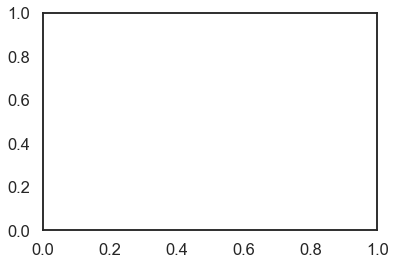

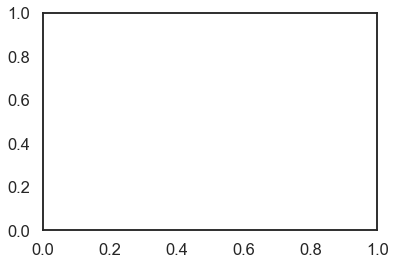

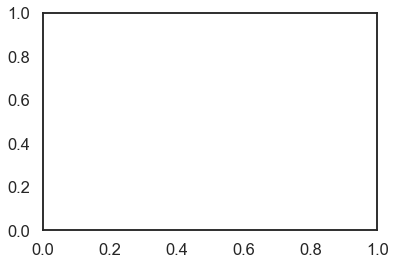

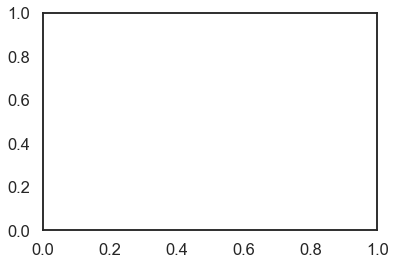

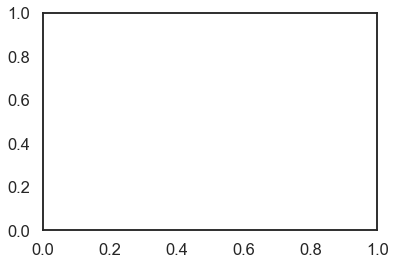

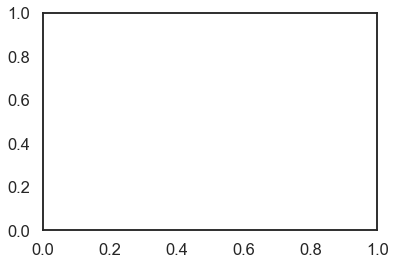

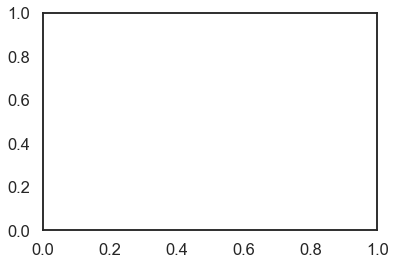

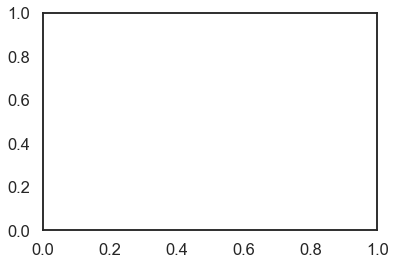

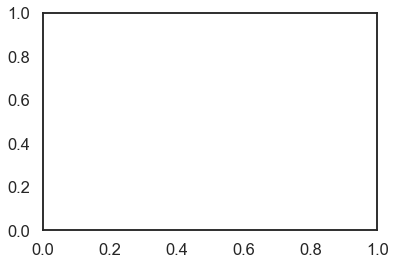

In [33]:
# plot mean network activation per state
for atlas in atlasnames:
    mean_netact_df = pd.read_csv(os.path.join(out_folder, 'movieDM_{0}_mean_netact.csv'.format(atlas)), index_col=0)
    sample_file = os.path.join(ts_folder, 'sub-NDARAA504CRN_task-movieDM_bold1_AP_Atlas_demean_detrend_resid0.9_filt_{0}.32k_fs_LR.ptseries.nii'.format(atlas))
    networks = nib.load(sample_file).header.get_axis(1).name
    for s in range(1,4):
        t = mean_netact_df.loc[mean_netact_df['state']==s]
        t = pd.melt(t, value_vars=atlas_info[atlas]['datalabels'], var_name='network', value_name='mean_activation') 
        fig, ax = plt.subplots()
        sns.catplot(data=t, kind='boxen',ci=None,x='network', y='mean_activation', 
                    palette=atlas_info[atlas]['plotcolors'], height=8, ax=ax)
        plt.axhline(y=0, color='k', linestyle='-')
        plt.xticks(range(len(atlas_info[atlas]['plotlabels'])),atlas_info[atlas]['plotlabels'], rotation=45, ha='right')
        plt.title('State {0}'.format(s))
        plt.ylabel('Activation (arbitrary units)')
        plt.xlabel('Network')
        plt.tight_layout()
        plt.savefig(os.path.join(out_folder,'group-movieDM_k3_{0}_state{1}_netmean_boxen.png'.format(atlas, s)), dpi=300)
        plt.close()

In [34]:
# compute sig net activation/deactivation
for atlas in atlasnames:
    mean_netact_df = pd.read_csv(os.path.join(out_folder, 'movieDM_{0}_mean_netact.csv'.format(atlas)), index_col=0)
    net_activation_stats = pd.DataFrame()
    i = 0
    for s in range(1,4):
        t = mean_netact_df.loc[mean_netact_df['state']==s]
        for j, net in enumerate(atlas_info[atlas]['datalabels']):
            tstat, pval = scp.ttest_1samp(t.loc[:,net], 0)
            net_activation_stats.loc[i, 'State'] = s
            net_activation_stats.loc[i, 'Network'] = atlas_info[atlas]['plotlabels'][j]
            net_activation_stats.loc[i, 't-stat'] = tstat
            net_activation_stats.loc[i, 'pval'] = pval
            net_activation_stats.loc[i, 'df'] = len(t.loc[:,net]) - 1
            net_activation_stats.loc[i, 'sig'] = pval<0.05
            net_activation_stats.loc[i, 'fdr_sig'] = pval<(0.05/len(atlas_info[atlas]['datalabels']))
            i = i + 1
    net_activation_stats.to_csv(os.path.join(out_folder, 'movieDM_k3_{0}_netact_ttests.csv'.format(atlas)))

# Relate brain states to movie data

In [35]:
def temporal_smooth(data, time, sampling_rate, window=4):
    """
    Parameters
    ----------
    data: numpy array
        1-D array with signal data to smooth.
    time: numpy array
        Time stamps in seconds for the signals to be smoothed.
    sampling_rate: float
        The sampling rate in Hz that the data were acquired in.
    window: int
        The size of the gaussian kernel to use for smoothing (must be even number).
    
    Returns
    -------
    smoothed: numpy array
        1-D array with smoothed data.
    
    """
    def gaussian(t, fwhm):
        return np.exp(-(4*np.log(2)*t**2)/fwhm**2)

    # create kernel
    n = len(time)
    k = int(window/2)
    gtime = np.arange(-k, k)/sampling_rate

    gauswin = gaussian(gtime, window)
    gauswin = gauswin/np.sum(gauswin)
    
    # zeropad the data
    pad_data = np.pad(data, (window,window), mode='constant', constant_values=0)
    
    # smooth data
    smoothed = np.zeros_like(pad_data)
    for i in range(k+1, n-k-1):
        smoothed[i] = np.sum(pad_data[i-k:i+k] * gauswin)
    # remove pad
    smoothed = smoothed[window:-window]
    return(smoothed)

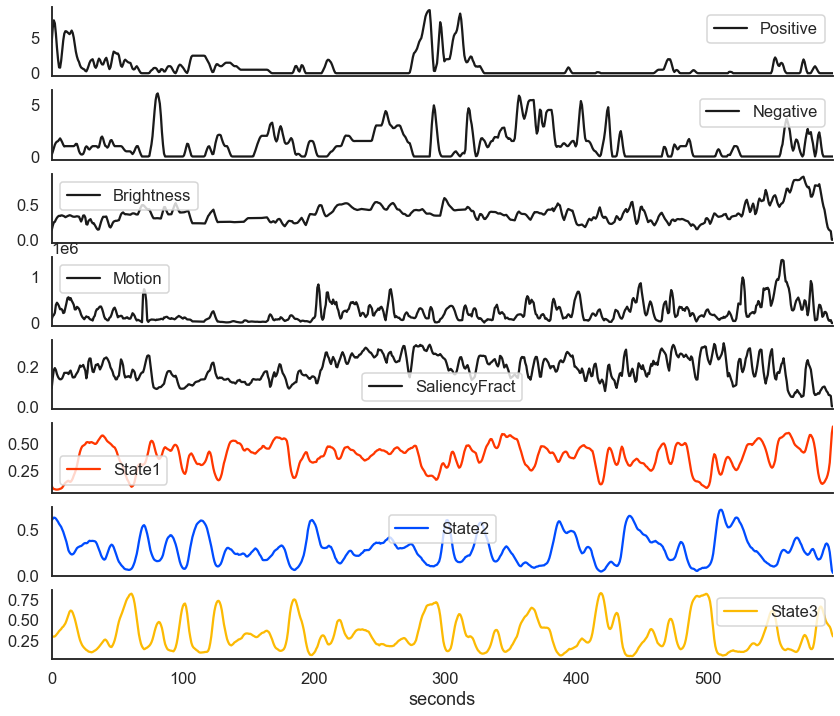

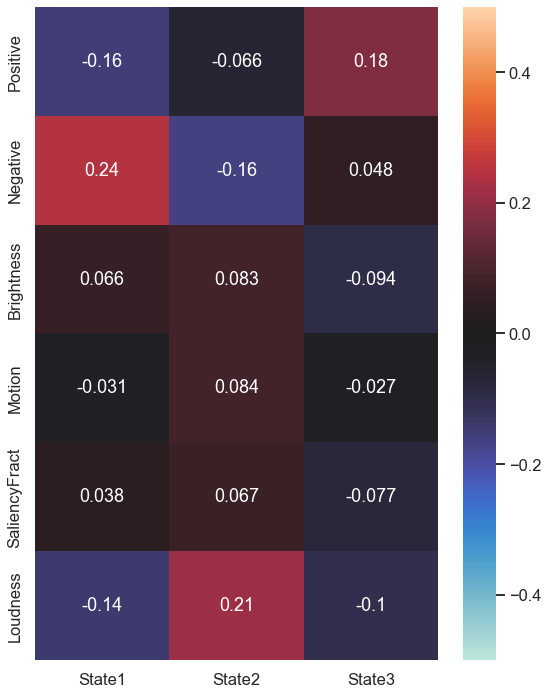

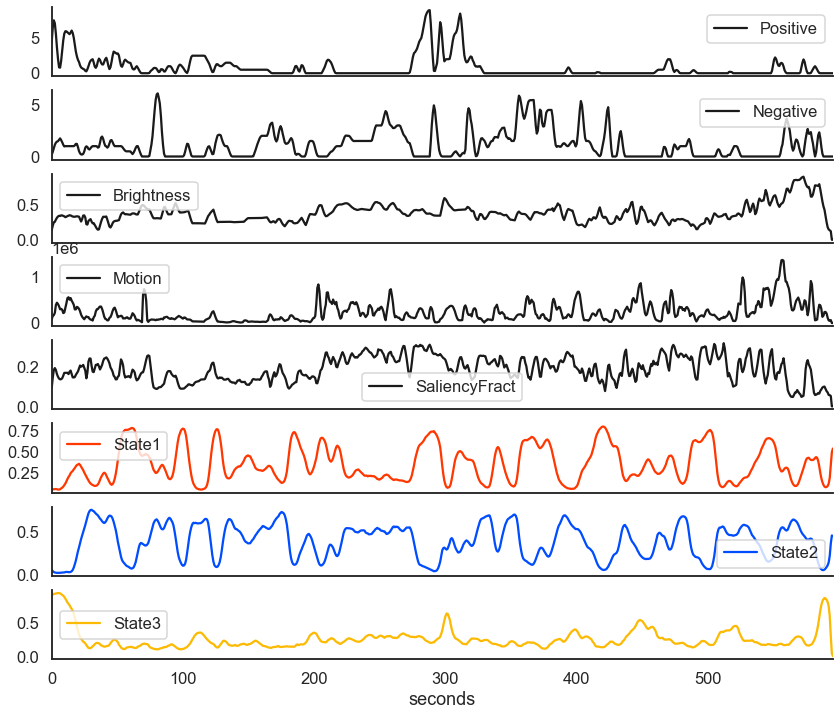

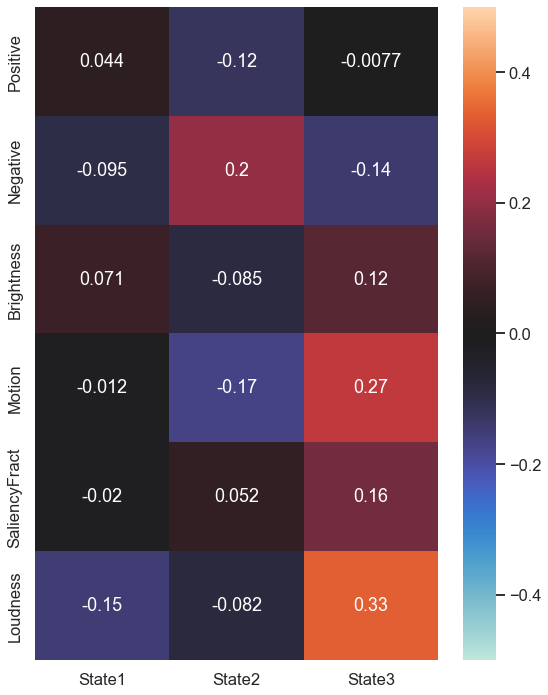

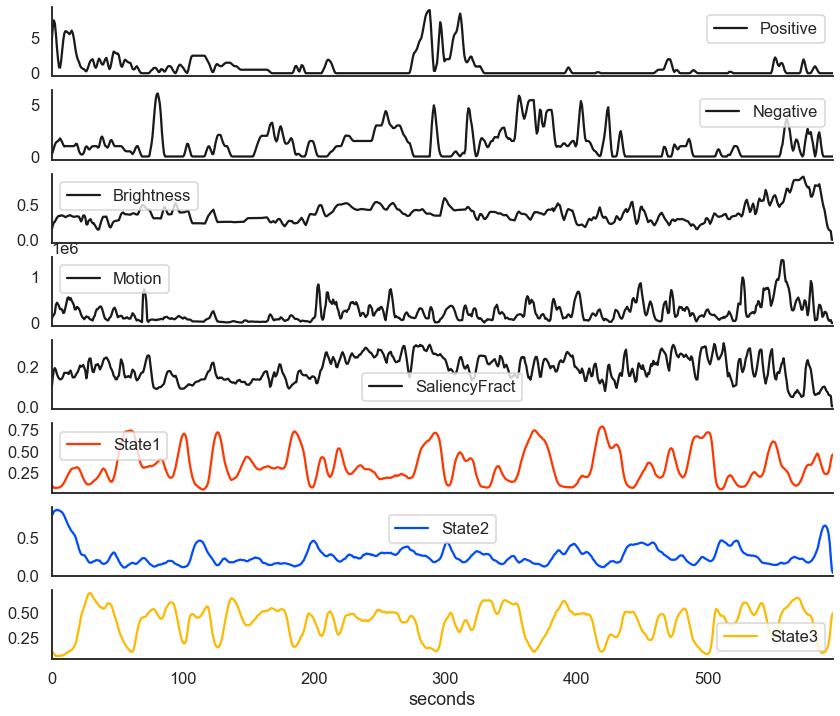

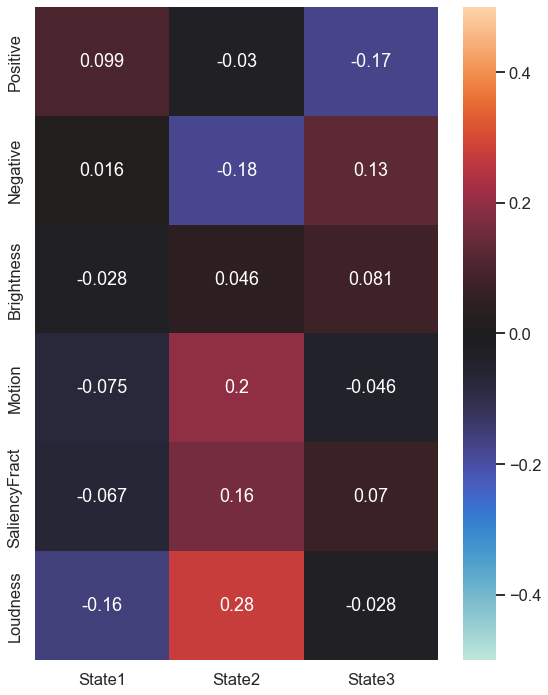

In [46]:
movie='DM'
for atlas in atlasnames:
    mean_prob = pd.read_csv(os.path.join(out_folder, 'movie{0}_k3_{1}_meanprobs.csv'.format(movie, atlas)), index_col=0)
    
    features = pd.read_csv(os.path.join(hbn_folder, 'HBN_video_coding','processing','v1','summary',
                                        '{0}_summary_codes_intuitivenames.csv'.format(movie)), index_col=0)
    for f in features.columns:
        features.loc[:,f] = temporal_smooth(features.loc[:,f], timing, 1.2)
    features = features.iloc[:-5,:]
    mean_prob_trim = mean_prob.iloc[5:,:]
    mean_prob_trim.columns = ['State1','State2','State3']
    mean_prob_trim.index = features.index
    combo = features.merge(mean_prob_trim, how='left', left_index=True, right_index=True)
    combo[['Positive','Negative','Brightness','Motion','SaliencyFract', 'State1','State2',
           'State3']].plot(subplots=True, figsize=(14,12), xlim=(0,timing[-6]), 
                                      color=['k','k','k','k','k']+state_palette)
    sns.despine()
    plt.savefig(os.path.join(out_folder,'group-movie{0}_k3_{1}_mean_probabilities_features.png'.format(movie, atlas)), dpi=300)
    plt.show()
    plt.close()
    
    c = combo.corr(method='spearman')
    plt.figure(figsize=(8,10))
    sns.heatmap(c.loc[['Positive','Negative','Brightness','Motion','SaliencyFract','Loudness'],
                      ['State1','State2','State3']], center=0, vmax=0.5, vmin=-0.5, annot=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_folder,'group-movie{0}_k3_{1}_corr_probabilities_features.png'.format(movie, atlas)), dpi=300)

In [48]:
# get state info for during and outside of negative content
movie='DM'
subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movie{0}.csv'.format(movie)), index_col=0)

#pull in features
features = pd.read_csv(os.path.join(hbn_folder, 'HBN_video_coding','processing','v1','summary',
                                    '{0}_summary_codes_intuitivenames.csv'.format(movie)), index_col=0)
for f in features.columns:
    features.loc[:,f] = temporal_smooth(features.loc[:,f], timing, 1.2)
features = features.iloc[:-5,:]
neg_mask = features['Negative']>1

for atlas in atlasnames:
# set up dataframe for outputs
    neg_df = pd.DataFrame()
    
    for i, sub in enumerate(subinfo.index):
        sub_states = np.load(os.path.join(out_folder,'sub','{0}_movie{1}_k{2}_{3}_states.npy'.format(sub, movie, nstates, atlas)))[5:]
        sub_probs = np.load(os.path.join(out_folder,'sub','{0}_movie{1}_k{2}_{3}_state_probabilities.npy'.format(sub, movie, nstates, atlas)))[5:,:]
        for s in range(1,4): 
            # Get percent of time in each state
            sub_neg_mask = (sub_states==s) & neg_mask
            sub_nonneg_mask = (sub_states==s) & (neg_mask==False)
            neg_df.loc[sub,'neg_s{0}_pct'.format(s)] = np.nanmean(sub_neg_mask)*100
            neg_df.loc[sub,'nonneg_s{0}_pct'.format(s)] = np.nanmean(sub_nonneg_mask)*100
            
            # get mean probability for each state
            neg_df.loc[sub,'neg_s{0}_prob'.format(s)] = np.nanmean(sub_probs[sub_neg_mask,:][:, s-1])
            neg_df.loc[sub,'nonneg_s{0}_prob'.format(s)] = np.nanmean(sub_probs[sub_nonneg_mask,:][:, s-1])
    
    # save data
    neg_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_states_info_{1}.csv'.format(movie, atlas)))

In [49]:
for atlas in atlasnames:
    odds_ratios = pd.DataFrame()
    subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movie{0}.csv'.format(movie)), index_col=0)
    
    #pull in features
    features = pd.read_csv(os.path.join(hbn_folder, 'HBN_video_coding','processing','v1','summary',
                                        '{0}_summary_codes_intuitivenames.csv'.format(movie)), index_col=0)
    for f in features.columns:
        features.loc[:,f] = temporal_smooth(features.loc[:,f], timing, 1.2)
    features = features.iloc[:-5,:]
    neg_mask = features['Negative']>1
    
    for sub in subinfo.index:
        substates = np.load(os.path.join(out_folder,'sub','{0}_movie{1}_k3_{2}_states.npy'.format(sub, movie, atlas))).astype(int)
        substates = substates[5:][neg_mask==True]
        # overall video
        subtransitions = np.zeros((nstates+1, nstates+1))
        subdifftransitions = np.zeros((nstates+1, nstates+1))
        for i in range(substates.shape[0]-1):
            s = substates[i]
            sn = substates[i+1]
            subtransitions[s,sn] = subtransitions[s,sn]+1
        marg0_subtra = np.sum(subtransitions, axis=0)
        odds = subtransitions/marg0_subtra
        states = [1, 2, 3]
        for s1 in states:
            for s2 in states:
                odds_ratios.loc[sub,'s{0}_to_{1}_neg'.format(s1,s2)] = odds[s1,s2]
                odds_ratios.loc[sub,'ntrans_s{0}_to_{1}_neg'.format(s1,s2)] = subtransitions[s1,s2]
        for i in range(1, nstates+1):
            states = [1, 2, 3]
            states.remove(i)
            odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_neg'.format(i, states[0],states[1])] = odds[i-1,states[0]]/odds[i-1,states[1]]
            odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_neg'.format(i, states[1],states[0])] = odds[i-1,states[1]]/odds[i-1,states[0]]
    odds_ratios = odds_ratios.replace(np.inf,np.nan)
    odds_ratios.to_csv(os.path.join(out_folder, 'movie{0}_sample_oddsratios_neg_{1}.csv'.format(movie, atlas)))

/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_62237/3035069114.py:24: RuntimeWarning: invalid value encountered in divide
  odds = subtransitions/marg0_subtra
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_62237/3035069114.py:33: RuntimeWarning: invalid value encountered in scalar divide
  odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_neg'.format(i, states[0],states[1])] = odds[i-1,states[0]]/odds[i-1,states[1]]
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_62237/3035069114.py:34: RuntimeWarning: invalid value encountered in scalar divide
  odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_neg'.format(i, states[1],states[0])] = odds[i-1,states[1]]/odds[i-1,states[0]]
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_62237/3035069114.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_neg'.format(i, states[0],states[1])] = odds[i-1,states[0]]/odds[i-1,states[1]]
/var/folders/c_/ms_vv4qx13